In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [3]:

# 1. 데이터 로드 및 전처리
def load_data(file_path, num_samples):
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['eng', 'fra', 'desc'])
    df = df.sample(n=num_samples).reset_index(drop=True)  # 샘플링
    input_texts = df['eng'].values.tolist()
    target_texts = ['<sos> ' + text + ' <eos>' for text in df['fra'].values.tolist()]
    return input_texts, target_texts

file_path = 'fra.txt'  # fra.txt 파일 경로
num_samples = 10000  # 사용할 샘플 수
input_texts, target_texts = load_data(file_path, num_samples)
input_texts[:5], target_texts[:5]

(['Is it really that important to you?',
  'Tom turned off the engine, but left the headlights on.',
  'Can I buy a ticket on the bus?',
  "I'm looking for my key.",
  'I thought you were having a good time.'],
 ['<sos> Est-ce si important pour toi\xa0? <eos>',
  '<sos> Tom a éteint le moteur mais a laissé les phares allumés. <eos>',
  '<sos> Je peux acheter un billet dans le bus\xa0? <eos>',
  '<sos> Je cherche ma clé. <eos>',
  "<sos> J'ai pensé que tu prenais du bon temps. <eos>"])

In [28]:
# 2. Tokenizer를 사용한 텍스트 토큰화 (구두점 유지)
tokenizer_inputs = Tokenizer(filters='')
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
max_encoder_seq_length = max([len(seq) for seq in input_sequences])

tokenizer_targets = Tokenizer(filters='')
tokenizer_targets.fit_on_texts(target_texts)

# <sos> 및 <eos> 토큰을 수동으로 추가
tokenizer_targets.word_index['<sos>'] = len(tokenizer_targets.word_index) + 1
tokenizer_targets.word_index['<eos>'] = len(tokenizer_targets.word_index) + 1

target_sequences = tokenizer_targets.texts_to_sequences(target_texts)
max_decoder_seq_length = max([len(seq) for seq in target_sequences])

num_encoder_tokens = len(tokenizer_inputs.word_index) + 1  # <pad> 토큰도 포함, OOV
num_decoder_tokens = len(tokenizer_targets.word_index) + 1


In [29]:
target_sequences[:7], target_texts[:7]

([[9940, 77, 38, 958, 26, 1754, 9940],
  [9940, 13, 17, 844, 10, 2369, 128, 17, 527, 22, 3798, 3799, 9940],
  [9940, 3, 64, 290, 15, 1139, 33, 10, 3800, 9940],
  [9940, 3, 845, 57, 1755, 9940],
  [9940, 24, 385, 6, 18, 3801, 42, 141, 170, 9940],
  [9940, 28, 155, 36, 139, 66, 279, 291, 1756, 9940],
  [9940, 19, 237, 2370, 188, 3802, 9940]],
 ['<sos> Est-ce si important pour toi\xa0? <eos>',
  '<sos> Tom a éteint le moteur mais a laissé les phares allumés. <eos>',
  '<sos> Je peux acheter un billet dans le bus\xa0? <eos>',
  '<sos> Je cherche ma clé. <eos>',
  "<sos> J'ai pensé que tu prenais du bon temps. <eos>",
  "<sos> C'est moi qui ai dit qu'on devrait attendre. <eos>",
  "<sos> Ce livre s'adresse aux débutants. <eos>"])

In [31]:
# 구두점이 잘 유지되는지 확인하기 위한 코드
print(tokenizer_targets.word_index)
print(tokenizer_targets.texts_to_sequences(target_texts[:5]))
target_texts[:5]

{'<sos>': 9940, '<eos>': 9940, 'je': 3, 'de': 4, 'pas': 5, 'que': 6, 'ne': 7, 'à': 8, 'la': 9, 'le': 10, '?': 11, 'vous': 12, 'tom': 13, 'il': 14, 'un': 15, 'est': 16, 'a': 17, 'tu': 18, 'ce': 19, 'nous': 20, 'en': 21, 'les': 22, 'une': 23, "j'ai": 24, 'suis': 25, 'pour': 26, 'me': 27, "c'est": 28, 'elle': 29, 'faire': 30, 'des': 31, 'te': 32, 'dans': 33, '!': 34, 'plus': 35, 'qui': 36, 'veux': 37, 'si': 38, 'se': 39, 'mon': 40, 'ça': 41, 'du': 42, 'tout': 43, 'fait': 44, 'au': 45, 'y': 46, 'avec': 47, 'et': 48, "qu'il": 49, 'cette': 50, 'sont': 51, 'son': 52, 'pourquoi': 53, 'être': 54, 'votre': 55, 'sur': 56, 'ma': 57, 'très': 58, 'pense': 59, 'ils': 60, "n'ai": 61, 'était': 62, 'sais': 63, 'peux': 64, 'ton': 65, 'dit': 66, "n'est": 67, 'où': 68, 'comment': 69, 'jamais': 70, 'été': 71, 'quelque': 72, 'sa': 73, 'chose': 74, 'vraiment': 75, 'ça.': 76, 'est-ce': 77, 'ont': 78, 'par': 79, 'êtes': 80, 'temps': 81, 'lui': 82, 'besoin': 83, 'cela': 84, 'sommes': 85, "s'est": 86, 'êtes-vous'

['<sos> Est-ce si important pour toi\xa0? <eos>',
 '<sos> Tom a éteint le moteur mais a laissé les phares allumés. <eos>',
 '<sos> Je peux acheter un billet dans le bus\xa0? <eos>',
 '<sos> Je cherche ma clé. <eos>',
 "<sos> J'ai pensé que tu prenais du bon temps. <eos>"]

In [17]:
max_encoder_seq_length, input_sequences[:3], num_encoder_tokens

(25,
 [[6, 21, 77, 10, 602, 3, 88],
  [7, 253, 175, 4, 3187, 113, 205, 4, 2100, 373],
  [39, 1, 165, 5, 1075, 32, 4, 1597]],
 6992)

In [18]:
max_decoder_seq_length, target_sequences[:3], num_decoder_tokens

(28,
 [[9940, 77, 38, 958, 26, 1754, 9940],
  [9940, 13, 17, 844, 10, 2369, 128, 17, 527, 22, 3798, 3799, 9940],
  [9940, 3, 64, 290, 15, 1139, 33, 10, 3800, 9940]],
 9940)

In [19]:
tokenizer_inputs.index_word

{1: 'i',
 2: 'you',
 3: 'to',
 4: 'the',
 5: 'a',
 6: 'is',
 7: 'tom',
 8: 'do',
 9: 'of',
 10: 'that',
 11: 'he',
 12: "don't",
 13: 'have',
 14: 'in',
 15: 'this',
 16: 'was',
 17: "i'm",
 18: 'for',
 19: 'my',
 20: 'your',
 21: 'it',
 22: 'are',
 23: 'we',
 24: 'be',
 25: 'what',
 26: 'want',
 27: 'me',
 28: 'like',
 29: 'she',
 30: 'know',
 31: 'not',
 32: 'on',
 33: 'you.',
 34: "you're",
 35: 'with',
 36: 'at',
 37: 'his',
 38: 'how',
 39: 'can',
 40: 'did',
 41: 'they',
 42: 'think',
 43: 'all',
 44: "it's",
 45: "can't",
 46: 'and',
 47: 'get',
 48: 'go',
 49: "didn't",
 50: 'will',
 51: 'if',
 52: 'no',
 53: 'me.',
 54: 'why',
 55: 'has',
 56: 'very',
 57: 'were',
 58: 'just',
 59: 'had',
 60: 'there',
 61: 'going',
 62: 'tell',
 63: 'about',
 64: "i'll",
 65: 'it.',
 66: 'that.',
 67: 'her',
 68: 'so',
 69: 'would',
 70: 'who',
 71: 'need',
 72: 'as',
 73: 'him',
 74: 'one',
 75: "i've",
 76: 'see',
 77: 'really',
 78: 'should',
 79: 'could',
 80: 'time',
 81: 'when',
 82: 't

In [20]:
tokenizer_targets.index_word

{1: '<sos>',
 2: '<eos>',
 3: 'je',
 4: 'de',
 5: 'pas',
 6: 'que',
 7: 'ne',
 8: 'à',
 9: 'la',
 10: 'le',
 11: '?',
 12: 'vous',
 13: 'tom',
 14: 'il',
 15: 'un',
 16: 'est',
 17: 'a',
 18: 'tu',
 19: 'ce',
 20: 'nous',
 21: 'en',
 22: 'les',
 23: 'une',
 24: "j'ai",
 25: 'suis',
 26: 'pour',
 27: 'me',
 28: "c'est",
 29: 'elle',
 30: 'faire',
 31: 'des',
 32: 'te',
 33: 'dans',
 34: '!',
 35: 'plus',
 36: 'qui',
 37: 'veux',
 38: 'si',
 39: 'se',
 40: 'mon',
 41: 'ça',
 42: 'du',
 43: 'tout',
 44: 'fait',
 45: 'au',
 46: 'y',
 47: 'avec',
 48: 'et',
 49: "qu'il",
 50: 'cette',
 51: 'sont',
 52: 'son',
 53: 'pourquoi',
 54: 'être',
 55: 'votre',
 56: 'sur',
 57: 'ma',
 58: 'très',
 59: 'pense',
 60: 'ils',
 61: "n'ai",
 62: 'était',
 63: 'sais',
 64: 'peux',
 65: 'ton',
 66: 'dit',
 67: "n'est",
 68: 'où',
 69: 'comment',
 70: 'jamais',
 71: 'été',
 72: 'quelque',
 73: 'sa',
 74: 'chose',
 75: 'vraiment',
 76: 'ça.',
 77: 'est-ce',
 78: 'ont',
 79: 'par',
 80: 'êtes',
 81: 'temps',
 

In [6]:

# 3. 데이터 패딩
encoder_input_data = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding='post')

# 디코더 타겟 데이터는 시프트된 버전이어야 함
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
for i, seq in enumerate(target_sequences):
    for t, word in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, word] = 1.0

In [7]:
encoder_input_data[:3], encoder_input_data.shape

(array([[   1,   28,    3, 1022,   13, 1384,  154,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [  36,    2,  696,   20,  822, 1385,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [   4,  166,   61,  392, 2563,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]], dtype=int32),
 (10000, 27))

In [8]:
decoder_input_data[:3], decoder_input_data.shape

(array([[   1,    3,   40,  674,   51, 1662,  151,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   71,    6,  185,    4,  992,  574, 3312,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   10, 2184,  108, 3313,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32),
 (10000, 30))

In [9]:
# 4. 모델 구성
latent_dim = 256 # 임베딩과 LSTM Cell vector에 공통으로 적용

# 인코더 설정
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]  # decoder에 전달할 문맥 vector (state)

# 디코더 설정
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states) # encoder에서 문맥 전달
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 컴파일
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy")


In [10]:

# 5. 콜백 함수 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('seq2seq_best_model.keras', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]


In [11]:
%%time

# 6. 모델 학습
# Epoch 46: val_loss did not improve from 1.25924
# 125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.8007 - val_loss: 1.2615 - learning_rate: 2.0000e-04
# Epoch 46: early stopping
# Restoring model weights from the end of the best epoch: 41.
# CPU times: user 5min 40s, sys: 22 s, total: 6min 2s
# Wall time: 4min

batch_size = 64
epochs = 100

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.8410
Epoch 1: val_loss improved from inf to 1.60369, saving model to seq2seq_best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 1.8397 - val_loss: 1.6037 - learning_rate: 0.0010
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.5595
Epoch 2: val_loss improved from 1.60369 to 1.57940, saving model to seq2seq_best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.5595 - val_loss: 1.5794 - learning_rate: 0.0010
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.5490
Epoch 3: val_loss improved from 1.57940 to 1.56621, saving model to seq2seq_best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.5489 - val_loss: 1.5662 - learning_rate: 0.0010
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.5213
Epoch 4: val_loss improved from 1.56621 to 1.55380, saving model to seq2seq_best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.521

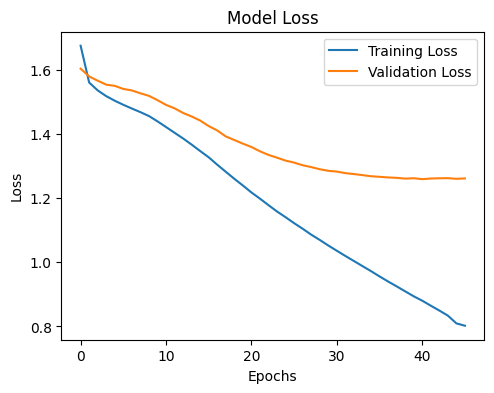

In [12]:
# 7. 학습 진행 상황 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습된 그래프 보여주기
plt.show()

In [13]:
# 8. 인퍼런스 모델 설정
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [18]:
# 9. 인퍼런스(번역) 함수 정의
reverse_input_word_index = dict((i, word) for word, i in tokenizer_inputs.word_index.items())
reverse_target_word_index = dict((i, word) for word, i in tokenizer_targets.word_index.items())

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    # Check if '<sos>' exists in word_index, otherwise use a default value or handle the case accordingly.
    start_token = tokenizer_targets.word_index.get('<sos>', 1)  # Assuming 1 is the index for an unknown token
    target_seq[0, 0] = start_token

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Handle the case where sampled_token_index might not be in reverse_target_word_index
        sampled_word = reverse_target_word_index.get(sampled_token_index, '<unk>')  # Replace with '<unk>' or handle unknown tokens
        decoded_sentence += ' ' + sampled_word

        if sampled_word == "<eos>" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

In [22]:
# 10. 테스트: 번역 예시 출력
for seq_index in range(10):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("입력 문장:", input_texts[seq_index])
    print("번역된 문장:", decoded_sentence)
    print("정답 문장:", target_texts[seq_index].replace('<sos> ', '').replace('<eos>', '')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
입력 문장: I want to continue this discussion tomorrow.
번역된 문장:  je veux que tu serais un chose
정답 문장: <sos> Je veux continuer cette discussion demain. <eos>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
-
입력 문장: Did you enjoy your winter holidays?
번역된 문장:  avez vous un peu de eos eos eos
정답 문장: <sos> Avez-vous passé de bonnes vacances d'hiver ? <eos>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━

In [20]:
encoder_input_data[seq_index : seq_index + 1]

array([[  12, 1751,   29,   42,  245,    3,  151,   49,   41,    3,    4,
         311,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

In [21]:
decode_sequence(input_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


' il a été broyé la maison de la'

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import nltk
from collections import defaultdict


In [33]:
# NLTK에서 사용할 토크나이저 다운로드
nltk.download('punkt')

# 1. 데이터 로드 및 전처리
def load_data(file_path, num_samples):
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['eng', 'fra'])
    df = df.sample(n=num_samples).reset_index(drop=True)  # 샘플링
    input_texts = df['eng'].values.tolist()
    target_texts = ['<sos> ' + text + ' <eos>' for text in df['fra'].values.tolist()]
    return input_texts, target_texts

file_path = 'fra.txt'  # fra.txt 파일 경로
num_samples = 10000  # 사용할 샘플 수
input_texts, target_texts = load_data(file_path, num_samples)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [34]:
# 2. NLTK를 사용한 텍스트 토큰화
def tokenize_texts(texts):
    tokenized_texts = [nltk.word_tokenize(text.lower()) for text in texts]
    return tokenized_texts

input_sequences = tokenize_texts(input_texts)
target_sequences = tokenize_texts(target_texts)

input_sequences[:5], target_sequences[:5]

([['je', "m'entends", 'très', 'bien', 'avec', 'ma', 'belle-mère', '.'],
  ["j'ai", 'peur', 'que', 'tom', 'ne', "s'en", 'remette', 'pas', '.'],
  ["j'ai", 'été', 'menacé', '.'],
  ['bravo', '!'],
  ['je', 'jetai', "l'étrange", 'paquet', 'sur', 'la', 'table', '.']],
 [['<',
   'sos',
   '>',
   'cc-by',
   '2.0',
   '(',
   'france',
   ')',
   'attribution',
   ':',
   'tatoeba.org',
   '#',
   '257309',
   '(',
   'ck',
   ')',
   '&',
   '#',
   '6560',
   '(',
   'sysko',
   ')',
   '<',
   'eos',
   '>'],
  ['<',
   'sos',
   '>',
   'cc-by',
   '2.0',
   '(',
   'france',
   ')',
   'attribution',
   ':',
   'tatoeba.org',
   '#',
   '7217336',
   '(',
   'ck',
   ')',
   '&',
   '#',
   '7960243',
   '(',
   'micsmithel',
   ')',
   '<',
   'eos',
   '>'],
  ['<',
   'sos',
   '>',
   'cc-by',
   '2.0',
   '(',
   'france',
   ')',
   'attribution',
   ':',
   'tatoeba.org',
   '#',
   '2247524',
   '(',
   'ck',
   ')',
   '&',
   '#',
   '4681754',
   '(',
   'sacredceltic',
   

In [ ]:



# 어휘 사전 생성
def build_vocab(tokenized_texts):
    vocab = defaultdict(lambda: len(vocab))
    vocab['<pad>'] = 0  # 패딩을 위한 토큰
    for text in tokenized_texts:
        for token in text:
            vocab[token]
    return dict(vocab)

input_vocab = build_vocab(input_sequences)
target_vocab = build_vocab(target_sequences)

# 텍스트를 시퀀스로 변환
def texts_to_sequences(tokenized_texts, vocab):
    return [[vocab[token] for token in text] for text in tokenized_texts]

input_sequences = texts_to_sequences(input_sequences, input_vocab)
target_sequences = texts_to_sequences(target_sequences, target_vocab)

# 시퀀스의 최대 길이 계산
max_encoder_seq_length = max([len(seq) for seq in input_sequences])
max_decoder_seq_length = max([len(seq) for seq in target_sequences])

num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [ ]:
# 3. 데이터 패딩
encoder_input_data = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding='post')

# 디코더 타겟 데이터는 시프트된 버전이어야 함
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
for i, seq in enumerate(target_sequences):
    for t, word in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, word] = 1.0

In [ ]:
# 4. 모델 구성
latent_dim = 256

# 인코더 설정
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# 디코더 설정
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 컴파일
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy")

In [ ]:
# 5. 콜백 함수 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('seq2seq_best_model.h5', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# 6. 모델 학습
batch_size = 64
epochs = 100

In [ ]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)

# 7. 학습 진행 상황 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습된 그래프 보여주기
plt.show()



In [ ]:

# 8. 인퍼런스 모델 설정
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)


In [ ]:

# 9. 인퍼런스(번역) 함수 정의
reverse_input_word_index = {v: k for k, v in input_vocab.items()}
reverse_target_word_index = {v: k for k, v in target_vocab.items()}

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_vocab['<sos>']

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' ' + sampled_word

        if sampled_word == "<eos>" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence.strip()


In [ ]:

# 10. 테스트: 번역 예시 출력
for seq_index in range(10):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("입력 문장:", input_texts[seq_index])
    print("번역된 문장:", decoded_sentence)
    print("정답 문장:", ' '.join(target_sequences[seq_index]))

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from nltk.tokenize import word_tokenize
import nltk

# nltk 패키지의 punkt 토크나이저 다운로드
nltk.download('punkt')

# 파일 경로 지정
file_path = 'fra.txt'

# 1. pandas를 사용하여 데이터 로드
data = pd.read_csv(file_path, delimiter='\t', header=None, names=['english', 'french', 'desc'])

# 영어 문장과 프랑스어 문장 리스트로 추출
english_sentences = data['english'].tolist()
french_sentences = data['french'].tolist()

# 2. nltk를 사용하여 영어 문장과 프랑스어 문장 토큰화
english_tokenized = [word_tokenize(sentence) for sentence in english_sentences]
french_tokenized = [word_tokenize(sentence) for sentence in french_sentences]

# 3. 토큰을 문자열로 결합하여 Tokenizer 사용 준비 (단어 레벨 토큰화 유지)
english_tokenized = [' '.join(tokens) for tokens in english_tokenized]
french_tokenized = [' '.join(tokens) for tokens in french_tokenized]

# Tokenizer 사용하여 시퀀스 변환
english_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=True)
french_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=True)

english_tokenizer.fit_on_texts(english_tokenized)
french_tokenizer.fit_on_texts(french_tokenized)

english_sequences = english_tokenizer.texts_to_sequences(english_tokenized)
french_sequences = french_tokenizer.texts_to_sequences(french_tokenized)

# 4. 패딩 적용
max_encoder_seq_length = max([len(seq) for seq in english_sequences])
max_decoder_seq_length = max([len(seq) for seq in french_sequences])

encoder_input_data = pad_sequences(english_sequences, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(french_sequences, maxlen=max_decoder_seq_length, padding='post')

# 5. 디코더 타겟 데이터 생성
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]

# 6. 모델에 필요한 변수 설정
num_encoder_tokens = len(english_tokenizer.word_index) + 1
num_decoder_tokens = len(french_tokenizer.word_index) + 1

# 7. Seq2Seq 모델 생성 (임베딩 추가)
latent_dim = 256
embedding_dim = 100

# 인코더
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# 디코더
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 8. 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=seq2seq_best_model.h5

In [ ]:
# 9. 콜백 함수 정의
checkpoint = ModelCheckpoint('seq2seq_best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [checkpoint, early_stopping]

# 10. 모델 학습
model.fit([encoder_input_data, decoder_input_data],
          tf.keras.utils.to_categorical(decoder_target_data, num_decoder_tokens),
          batch_size=64,
          epochs=50,
          validation_split=0.2,
          callbacks=callbacks)

# 11. 최적 모델 로드
model.load_weights('seq2seq_best_model.keras')
model.save('seq2seq_translation_with_embedding.keras')

print("Model training complete and saved as 'seq2seq_translation_with_embedding.h5'")

# 12. 모델 검증을 위한 인코더 및 디코더 모델 정의
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더를 위한 입력
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 임베딩 및 LSTM
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# 최종 디코더 모델 정의
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# 13. 시퀀스를 텍스트로 변환하는 함수 정의
reverse_eng_word_index = {v: k for k, v in english_tokenizer.word_index.items()}
reverse_french_word_index = {v: k for k, v in french_tokenizer.word_index.items()}

def decode_sequence(input_seq):
    # 인코더의 상태를 가져옵니다.
    states_value = encoder_model.predict(input_seq)

    # 프랑스어로 시작하는 토큰을 생성합니다.
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = french_tokenizer.word_index['\t']

    # 번역된 문장 저장을 위한 리스트
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측된 토큰을 텍스트로 변환합니다.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_french_word_index.get(sampled_token_index, '')

        decoded_sentence += sampled_char + ' '

        # 종료 조건: 최대 길이 도달 또는 종료 토큰 예측
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # 다음 입력 토큰을 업데이트합니다.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트합니다.
        states_value = [h, c]

    return decoded_sentence

# 14. 검증: 예제 문장 번역
for seq_index in range(10):
    input_seq = encoder_input_data[seq_index:seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('-')
    print('Input sentence:', english_sentences[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Actual sentence:', french_sentences[seq_index])
